In [44]:
options(warn=-1)
# load library
library(reshape2) # for melt and cast functions
library(ggplot2) # for plotting functions
library(tm) # text mining library
#install.packages("SnowballC")
library(SnowballC)

## Question 1

### 1. Derive expectation and maximation steps of hard-EM algorithm for document clustering

- N is the total number of documents, K is the number of clusters.
- {d1....dn} are the documents, with corresponding latent variables {z1...zn) where zn:=(zn1,....,znk) is the cluster assignment vector for the nth documents, znk = 1 if the document belongs to the cluster k and zero otherwise. 
- Parameters: Phi k is the cluster proportion,and mu k is the word proportion. Where the sum of phi of all clusters equal to 1 and the sum of word proportion of all words in cluster k equal to 1.
\begin{equation}
\sum_{k=1}^{K} \varphi_{k}=1
\end{equation}

and 

\begin{equation}
\sum_{w \in \mathcal{A}} \mu_{k, w}=1
\end{equation}

Then the probability of observed documents is given by:
\begin{equation}
\begin{aligned}
p\left(d_{1}, \ldots, d_{N}\right)=\prod_{n=1}^{N} p\left(d_{n}\right) &=\prod_{n=1}^{N} \sum_{k=1}^{K} p\left(z_{n, k}=1, d_{n}\right) \\
&=\prod_{n=1}^{N} \sum_{k=1}^{K}\left(\varphi_{k} \prod_{w \in \mathcal{A}} \mu_{k, w}^{c\left(w, d_{n}\right)}\right)
\end{aligned}
\end{equation}


Apply log to above, then the log-likelihood is:

\begin{equation}
\begin{aligned}
\ln p\left(d_{1}, \ldots, d_{N}\right)=\sum_{n=1}^{N} \ln p\left(d_{n}\right) &=\sum_{n=1}^{N} \ln \sum_{k=1}^{K} p\left(z_{n, k}=1, d_{n}\right) \\
&=\sum_{n=1}^{N} \ln \sum_{k=1}^{K}\left(\varphi_{k} \prod_{w \in \mathcal{A}} \mu_{k, w}^{c\left(w, d_{n}\right)}\right)
\end{aligned}
\end{equation}


To maximise the Likelihood of incomplete Data, we use EM algorithm.

First, as the parameters are unknown, we initialize the starting values of parameters θ. These values will be called θold, and the unknown parameters we want to estimate will be θnew. 

\begin{equation}
\theta^{\text {old }}=\left(\boldsymbol{\varphi}^{\text {old }}, \boldsymbol{\mu}_{1}^{\text {old }}, \ldots, \boldsymbol{\mu}_{K}^{\text {old }}\right)
\end{equation}

Define Q function:

\begin{equation}
\begin{aligned}
Q\left(\boldsymbol{\theta}, \boldsymbol{\theta}^{\text {old }}\right) &:=\sum_{n=1}^{N} \sum_{k=1}^{K} p\left(z_{n, k}=1 \mid d_{n}, \boldsymbol{\theta}^{\text {old }}\right) \ln p\left(z_{n, k}=1, d_{n} \mid \boldsymbol{\theta}\right) \\
&=\sum_{n=1}^{N} \sum_{k=1}^{K} p\left(z_{n, k}=1 \mid d_{n}, \boldsymbol{\theta}^{\text {old }}\right)\left(\ln \varphi_{k}+\sum_{w \in \mathcal{A}} c\left(w, d_{n}\right) \ln \mu_{k, w}\right) \\
&=\sum_{n=1}^{N} \sum_{k=1}^{K} \gamma\left(z_{n, k}\right)\left(\ln \varphi_{k}+\sum_{w \in \mathcal{A}} c\left(w, d_{n}\right) \ln \mu_{k, w}\right)
\end{aligned}
\end{equation}

where 

\begin{equation}
\gamma\left(z_{n, k}\right) = p\left(z_{n, k}=1 \mid d_{n}, \boldsymbol{\theta}^{\text {old }}\right)
\end{equation}

are the responsability factors

E step: 
1. calculate γ(znk) based on estimated parameters
\begin{equation}
\gamma\left(z_{n k}\right):=p\left(z_{n k}=1 \mid \boldsymbol{d}_{n}, \boldsymbol{\theta}^{\text {old }}\right)
\end{equation}

2. for each document, find the cluster with the maximum probability. 

\begin{equation}
Z^{*}=\operatorname{argmax}_{z} \gamma\left(z_{n, k}\right)=\operatorname{argmax}_{z} p\left(z_{n, k}=1 \mid d_{n}, \theta^{\text {old }}\right)
\end{equation}

M step:

For hard EM, there is no expectation on the latent variables, so :

\begin{equation}
\mathcal{Q}\left(\theta, \theta^{\text {old }}\right)=\sum_{n=1}^{N} \ln p\left(z_{n, k=Z^{*}}=1, d_{n} \mid \theta\right)
\end{equation}

Find: 
\begin{equation}
\operatorname{argmax}_{\theta} \sum_{n=1}^{N}\left(\ln \varphi_{k=Z^{*}}+\sum_{w \in \mathcal{A}} c\left(w, d_{n}\right) \ln \mu_{k=Z^{*}, w}\right)
\end{equation}

1. Sub the z* calculated into the partial derivatives below and recalculate the estimations of the parametors, update the parameters.


\begin{equation}
\varphi_{k}=\frac{N_{k}}{N} \text { where } N_{k}:=\sum_{n=1}^{N} \gamma\left(z_{n, k}\right)
\end{equation}

and 

\begin{equation}
\mu_{k, w}=\frac{\sum_{n=1}^{\prime} \gamma\left(z_{n, k}\right) c\left(w, d_{n}\right)}{\sum_{w^{\prime} \in \mathcal{A}} \sum_{n=1}^{N} \gamma\left(z_{n, k}\right) c\left(w^{\prime}, d_{n}\right)}
\end{equation}

Use \begin{equation}
\boldsymbol{\theta}^{\text {old }} \leftarrow \boldsymbol{\theta}^{\text {new }}
\end{equation} and repeat until converge


### 2. Implement the hard-EM and soft-EM

In [106]:
# Initialize parameters (theta_old function)
theta <- function(size, K, seed = 123456){
    set.seed(seed)     # set seed
    phi.hat  <- matrix(1/K,nrow = K, ncol=1) # assume all clusters have the same size (we will update this later on)
    mu.hat <- matrix(runif(K*size),nrow = K, ncol = size)    # initiate Mu 
    mu.hat <- prop.table(mu.hat, margin = 1)   # normalization to ensure that sum of each row is 1
    
    return (list("phi.hat" = phi.hat, "mu.hat" = mu.hat))
}

# Helper Function 
# This function is needed to prevent numerical overflow/underflow when working with small numbers
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [107]:
# train objective function
train_obj <- function(theta_old, wf) { 
  N <- dim(wf)[2] # number of documents
  K <- dim(theta_old$mu.hat)[1] # number of cluster
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K) 
    for (k in 1:K){
      lprob[k,1] = sum(wf[,n] * log(theta_old$mu.hat[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(theta_old$phi))
  }
  
  return (nloglike)
}

In [47]:
# EM function for document clustering(hard & soft)
EM.step <- function(wf, K = 4, max.epoch=10, soft = TRUE, seed){ 
    
    # Parameters Setting
    N <- ncol(wf) # number of documents
    W <- nrow(wf)   # number of words i.e. vocabulary size
    theta_old = theta(W, K, seed = seed) # initialize parameters
    gamma <- matrix(,nrow=N, ncol=K)  # empty posterior matrix
    
    # check initial values
    print(train_obj(theta_old,wf))
    # EM-step
    for(epoch in 1:max.epoch){
        
        
        # E step:    
        for (n in 1:N){
            for (k in 1:K){
                ## calculate the posterior based on the estimated mu and rho in the "log space"
                gamma[n,k] <- log(theta_old$phi.hat[k]) +  sum(wf[,n] * log(theta_old$mu.hat[k,])) 
            }
            # normalisation to sum to 1 in the log space
            logZ = logSum(gamma[n,])
            gamma[n,] = gamma[n,] - logZ
        }
        
        # converting back from the log space 
        gamma <- exp(gamma)
        
        # for hard EM, we want the k with the highest probability to be 1
        if(soft == FALSE){
            # hard assignments:
            max.prob <- gamma==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
            gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
            gamma[!max.prob] <- 0 # remove points from clusters with lower probabilites
        }
        
        
        # M step:
        # we need this matrix (same shape as the ) here because when calculating mean, 
        # it can result in zero which leads to log calculation result in NaN, to avoid this issue, add a small number to avoid 0
        eps = matrix(1e-10, nrow = W, ncol = K)
        for (k in 1:K){
            ## recalculate the estimations:
            theta_old$phi.hat[k] <- sum(gamma[,k])/N  # the cluster size
            theta_old$mu.hat[k,] <- ((wf%*%gamma[,k])+eps[,k])/sum((wf%*%gamma[,k])+eps[,k]) # new means (cluster cenroids)
            }
        # evaluate and compare likelihood
        print(train_obj(theta_old,wf))
    }
    
    # keep the final parameters and gamma (posterior matrix)
    return(list("theta"= theta_old,"posterior"=gamma))
}

### 3. run soft-EM and hard-EM on provided data with K = 4

In [139]:
## read the file (each line of the text file is one document)
text <- readLines('./Task2A.txt')

## the terms before '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
docs <- strsplit(text, '\t')
rm(text) # just free some memory!

# store the labels for evaluation
labels <- unlist(lapply(docs, function(x) x[1]))

# store the unlabeled texts    
docs <- data.frame(unlist(lapply(docs, function(x) x[2])))                          

In [140]:
# preprocessing
docs$doc_id <- rownames(docs)
colnames(docs) <- c("text","doc_id")

# create a corpus
docs <- DataframeSource(docs)
corp <- Corpus(docs)

# Preprocessing:
corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words 
#(the most common word in a language that can be find in any document)
corp <- tm_map(corp, removePunctuation) # remove punctuation
corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
corp <- tm_map(corp, removeNumbers) # remove all numbers
corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 

# Create a matrix which its rows are the documents and colomns are the words. 
# Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(corp)
# reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.90)

# store word frequency into a matrix
wf <- t(as.matrix(dtm))

In [144]:
# run soft and hard EM
EM_soft <- EM.step(wf, K=4, max.epoch=15,soft = TRUE, seed = 123456) 
EM_hard <- EM.step(wf, K=4, max.epoch=15,soft = FALSE, seed = 123456) 

[1] 459718.3
[1] 425849.8
[1] 422287.2
[1] 420268.8
[1] 419696.7
[1] 419511.3
[1] 419432.7
[1] 419403
[1] 419385.8
[1] 419303.3
[1] 419291.5
[1] 419283
[1] 419274.8
[1] 419248.1
[1] 419226.4
[1] 419218.6
[1] 459718.3
[1] 425717.5
[1] 422187.1
[1] 420212.3
[1] 419695.3
[1] 419536.1
[1] 419450
[1] 419417.2
[1] 419402
[1] 419394.1
[1] 419387.3
[1] 419383.3
[1] 419382.4
[1] 419382.5
[1] 419382.5
[1] 419382.5


### 4. Perform PCA on clustering

In [162]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(counts, color.vector, title=' '){
    # PCA
    p.comp <- prcomp(counts, scale. = TRUE, center = TRUE)
    # visualize
    plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

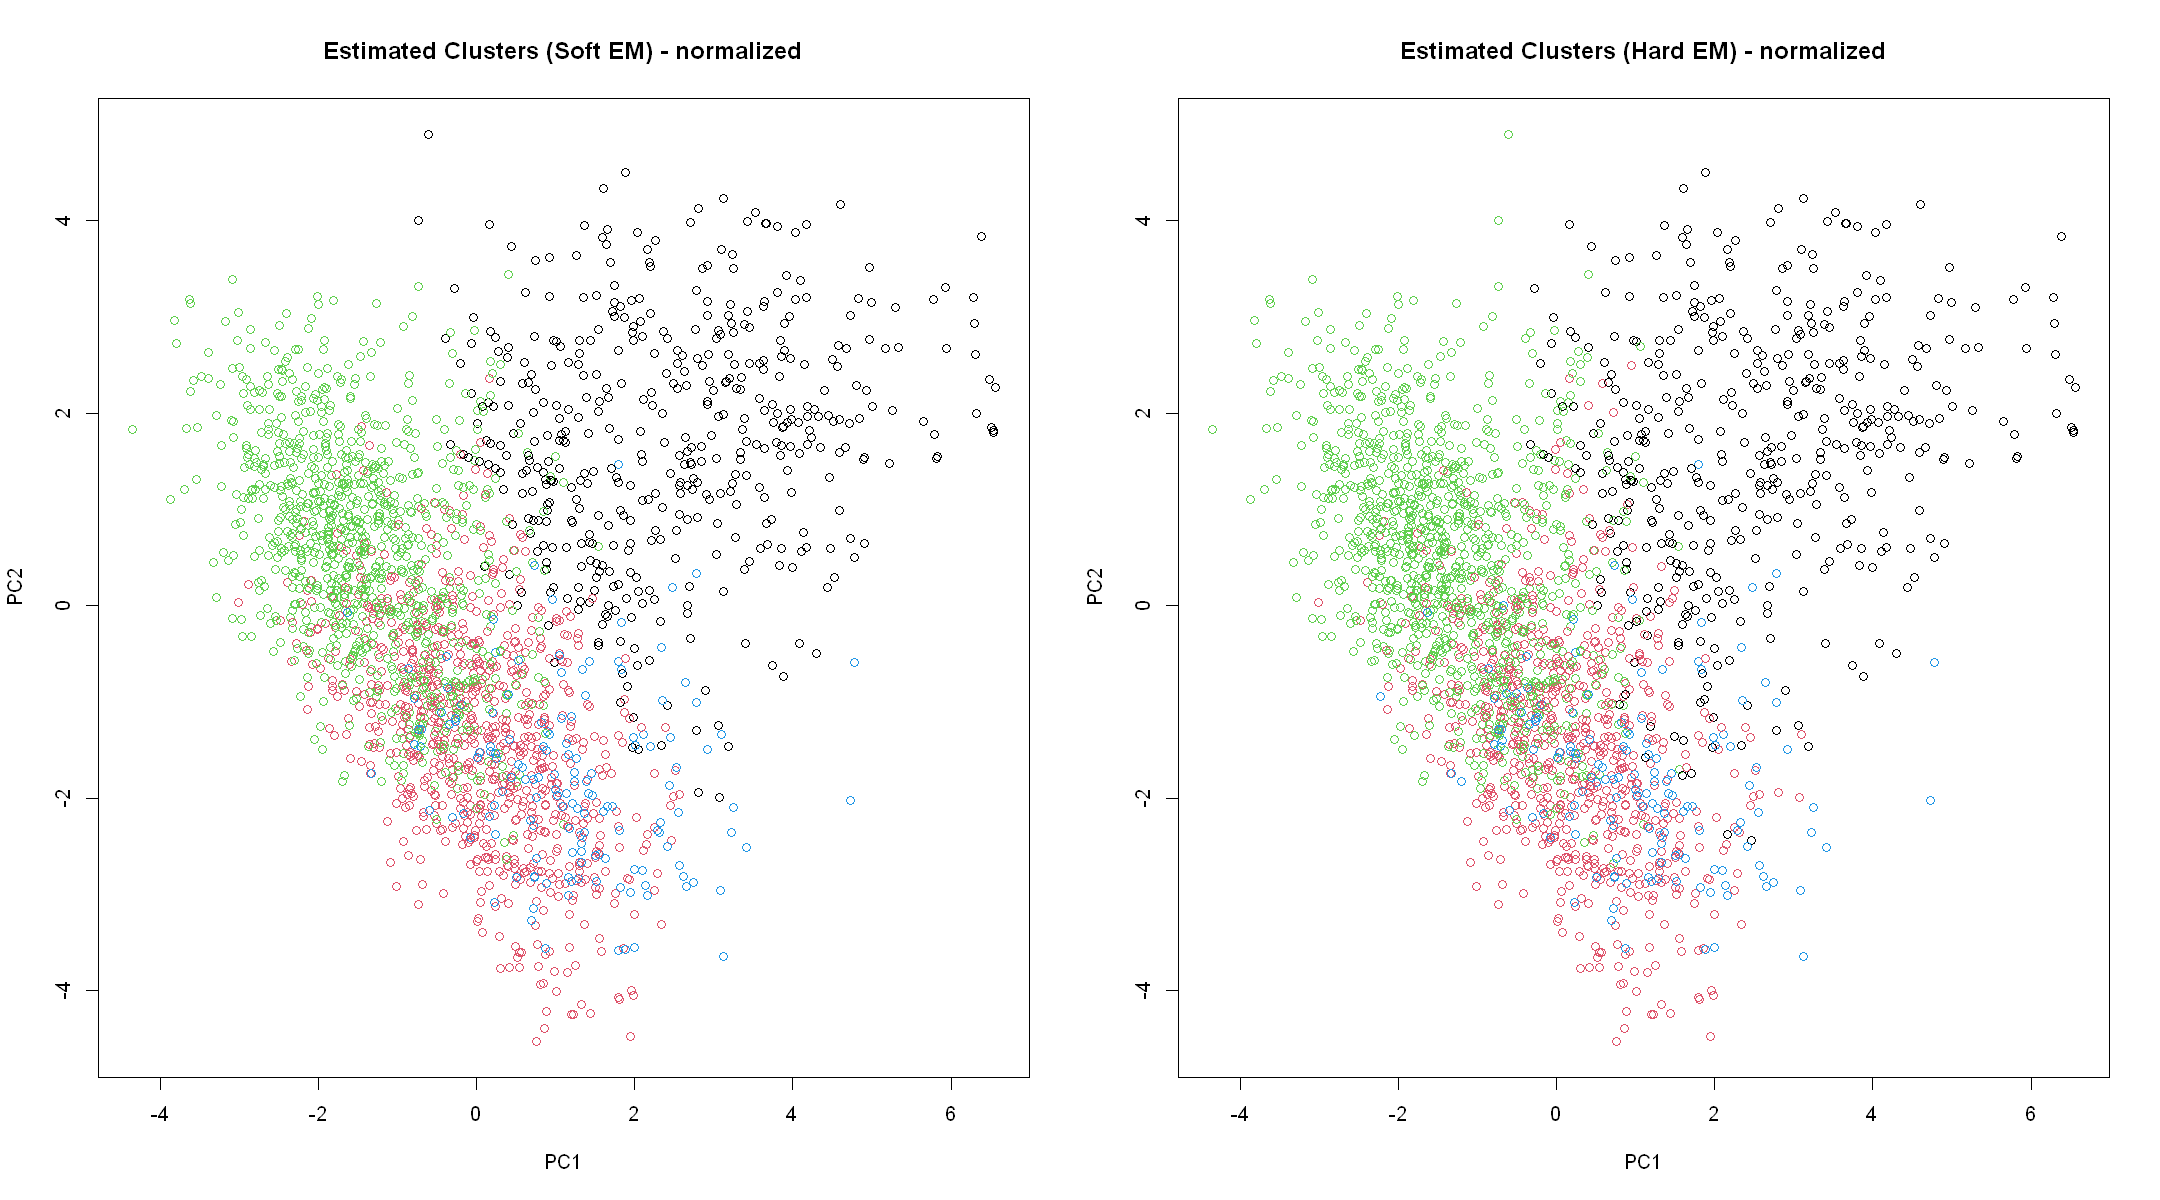

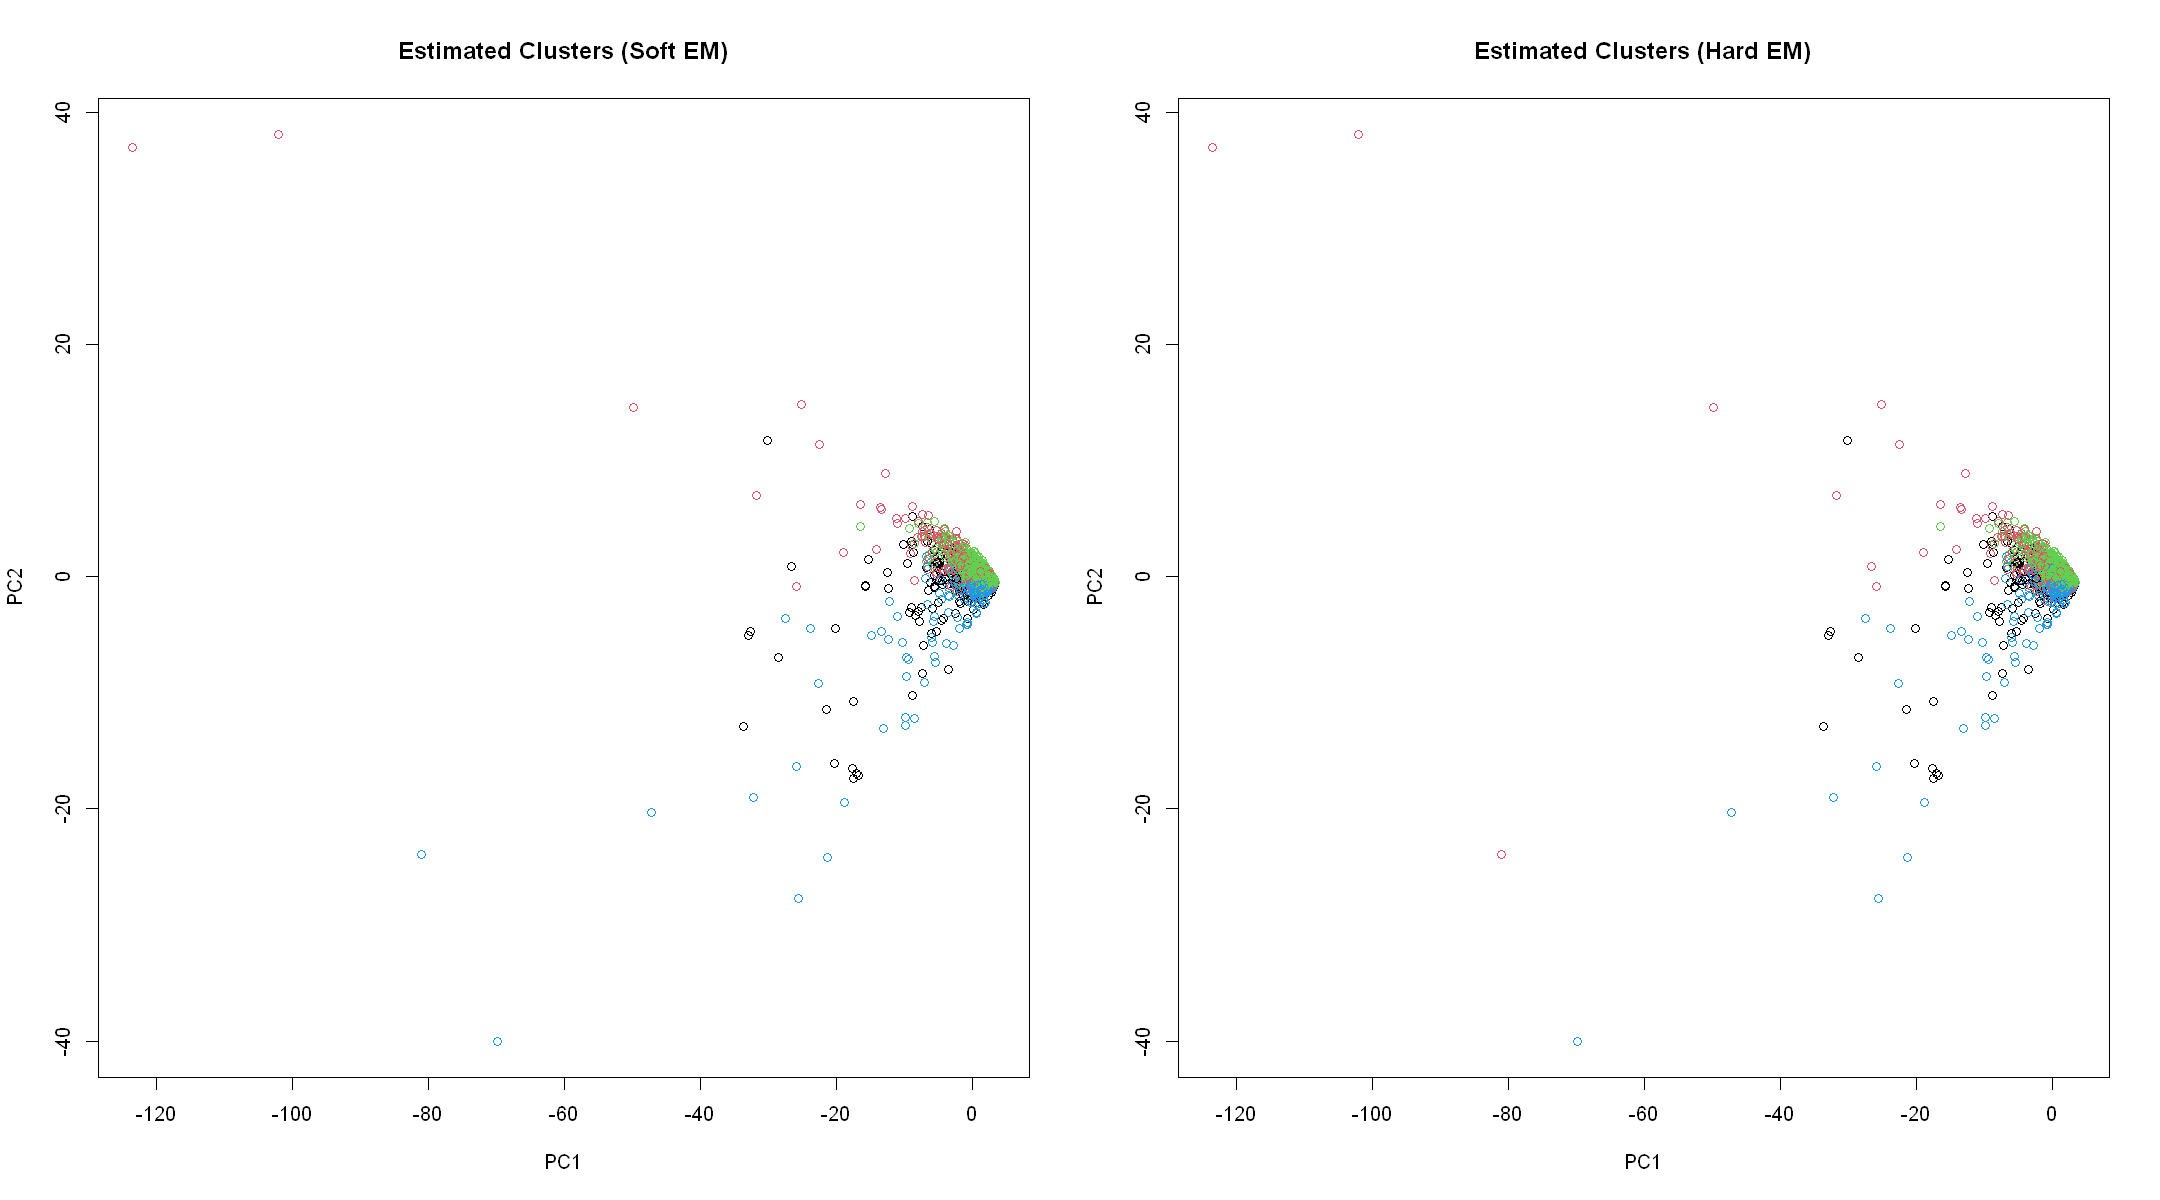

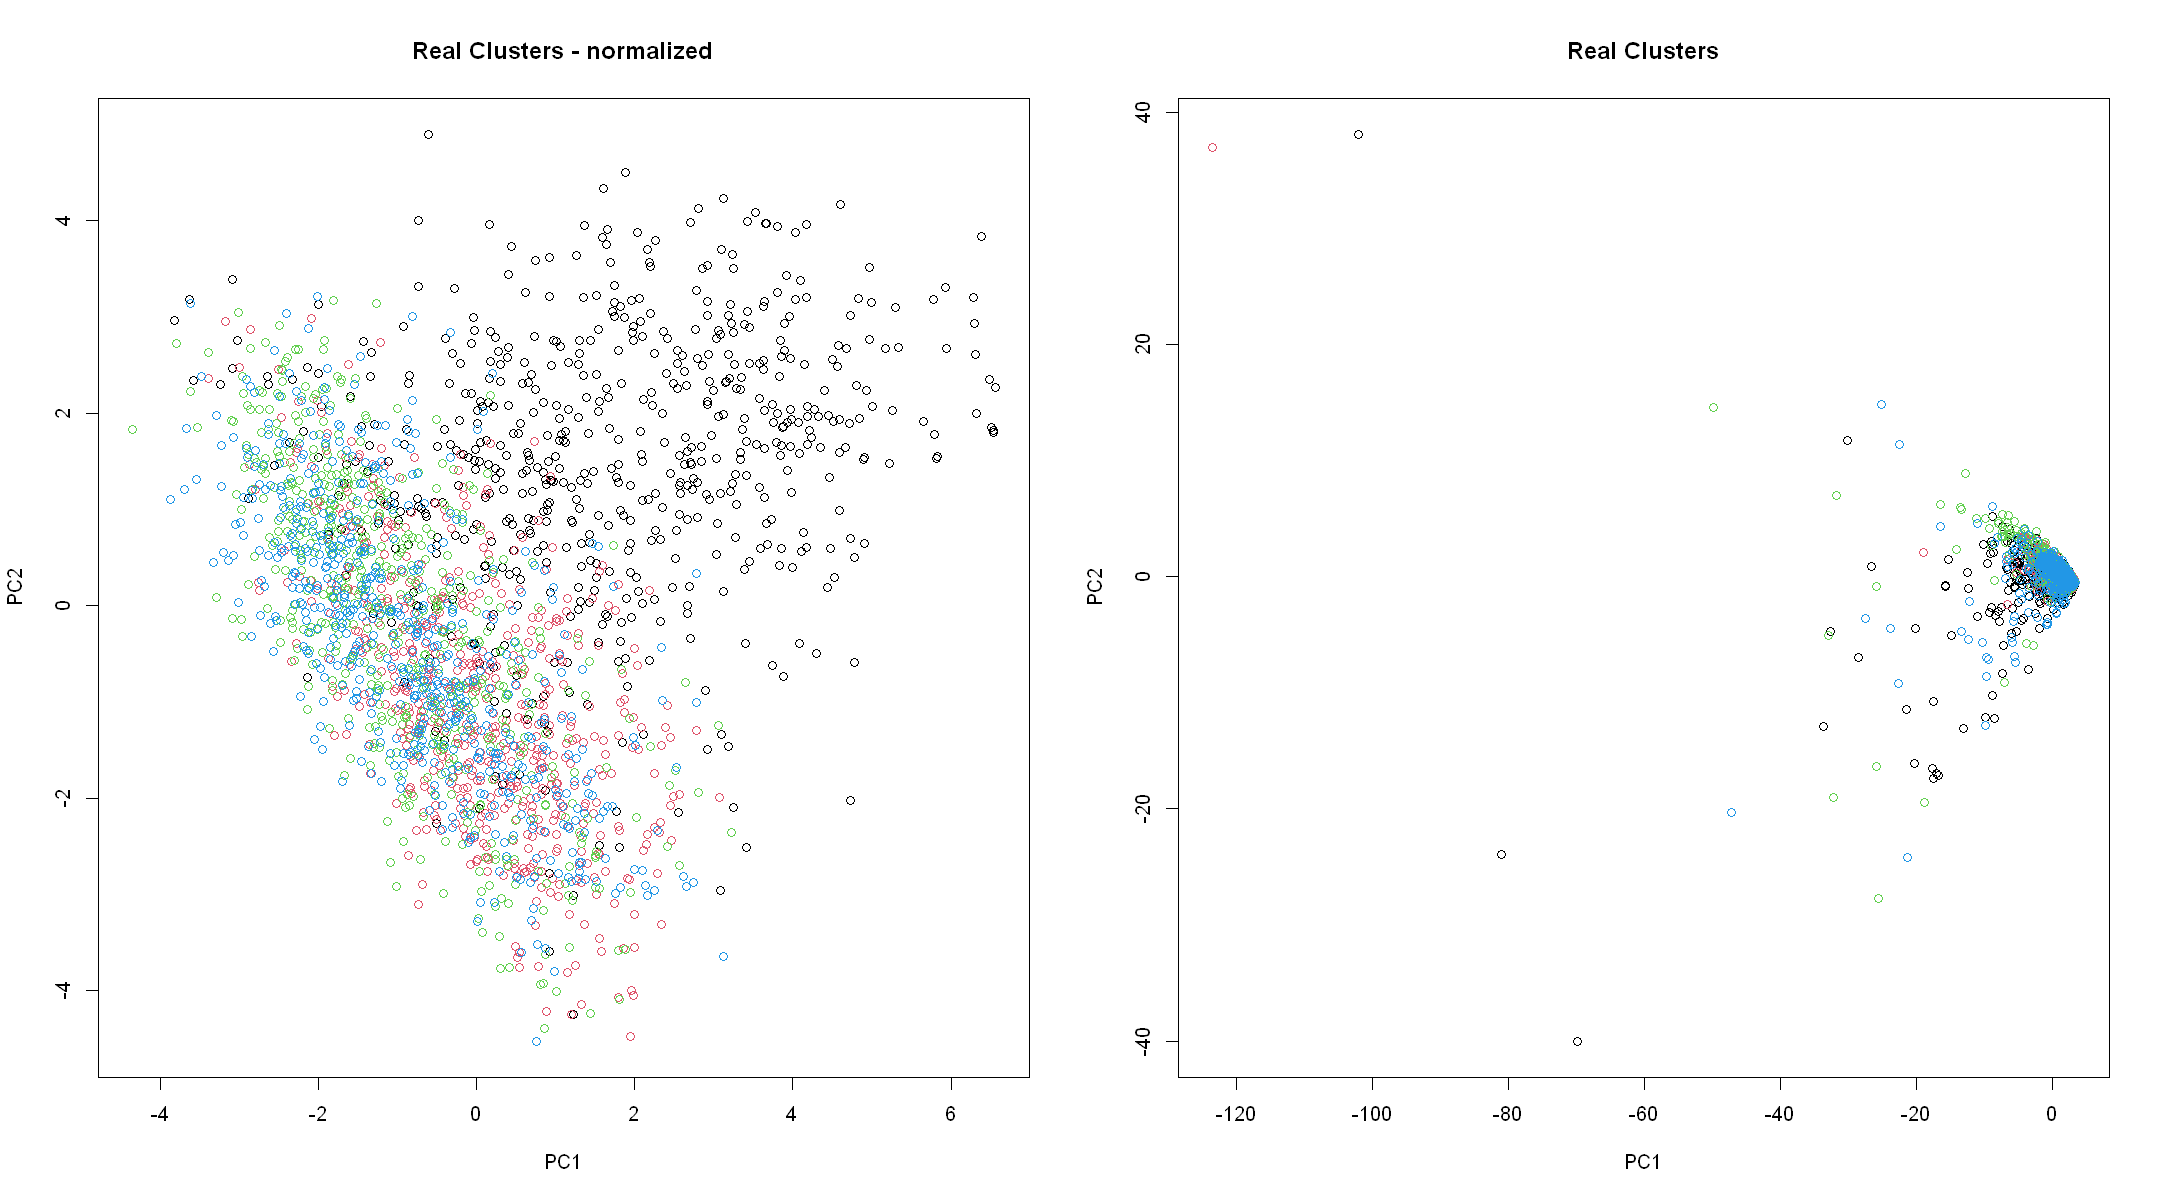

In [163]:
# visualization settings
options(repr.plot.width=18, repr.plot.height=10)
par(mfrow=c(1,2))

# Get the color.vector(labels) 
label.soft  <- apply(EM_soft$posterior, 1, which.max)
label.hard  <- apply(EM_hard$posterior, 1, which.max)

# normalize the count matrix for better visualization
counts <- scale(wf)
counts[is.nan(counts)] <- 0

# visualize the clusters estimated by soft and hard EM
cluster.viz(t(counts), label.soft, 'Estimated Clusters (Soft EM) - normalized')
cluster.viz(t(counts), label.hard, 'Estimated Clusters (Hard EM) - normalized')
cluster.viz(t(wf), label.soft, 'Estimated Clusters (Soft EM)')
cluster.viz(t(wf), label.hard, 'Estimated Clusters (Hard EM)')
# visualize the real clusters
cluster.viz(t(counts), factor(labels), 'Real Clusters - normalized')
cluster.viz(t(wf), factor(labels), 'Real Clusters')